# Ninth Exercise (HPO)

This exercise focuses on hyperparameter optimization with neural networks.

We will
- define hyperparameter-configuration search-spaces
- train deep learning models with various hyper parameters
- use random search as a basic hyperparameter optimizer
- use BOHB as an advanced hyperparameter optimizer

It's in the nature of hyperparameter optimization, that you'll have to train a lot of models. 
Therefore execution time will be longer in this exercise, running the completed notebook takes about 30 minutes on a tutor's 3 year old laptop.

#### Install HpBandster and torchvision

You need to install two more python packages for this exercise.

- [torchvision](https://pytorch.org/docs/stable/torchvision/) provides utility methods for pytorch.
- [HpBandSter](https://github.com/automl/HpBandSter) is a fast, parallel implementation of several hyperparameter optimizers.  
   We can define even complex hyperparameter search spaces with [ConfigSpace](https://github.com/automl/ConfigSpace), which comes along HpBandSter as dependency.


Install with anaconda/conda
```
conda install torchvision
conda install hpbandster
```

or with plain python
```
pip3 install torchvision
pip3 install hpbandster
```

In [3]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install hpbandster

  Created wheel for hpbandster: filename=hpbandster-0.7.4-cp37-none-any.whl size=80012 sha256=4c5bf9d3451edbed16994deca66b4f9dd0567d3100039d2619e33467f3958dba
  Stored in directory: C:\Users\Abdelrahman ElNagi\AppData\Local\pip\Cache\wheels\9d\57\62\6b00c8011bac96e0c404adc5be4e16964ba4544614240b4e23
  Created wheel for ConfigSpace: filename=ConfigSpace-0.4.12-cp37-cp37m-win_amd64.whl size=689388 sha256=c23576fd673b69ce6f534a5b14a8275888c2a6043c86e22b9c2fc4fcd73adb6d
  Stored in directory: C:\Users\Abdelrahman ElNagi\AppData\Local\pip\Cache\wheels\ae\b2\85\feafec2387f97065d914a72c42ff3a0f6f60d8e1fd03c6bd4b
Successfully built hpbandster ConfigSpace
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from typing import Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms

import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# NOT CHANGE!
np.random.seed(0)

def load_mnist_minibatched(batch_size: int, n_train: int = 8192, n_valid: int = 1024,
                           valid_test_batch_size: int = 1024) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_dataset = torchvision.datasets.MNIST(
        root='../data', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(
        root='../data', train=False, transform=transforms.ToTensor())

    train_sampler = SubsetRandomSampler(range(n_train))
    validation_sampler = SubsetRandomSampler(range(n_train, n_train+n_valid))

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset=train_dataset, batch_size=valid_test_batch_size,
                                   sampler=validation_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=valid_test_batch_size, 
                                              shuffle=False)
    return train_loader, validation_loader, test_loader


def evaluate_accuracy(model: nn.Module, data_loader: DataLoader) -> float:
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in data_loader:
            output = model(x)
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(y.view_as(pred)).sum().item()
    accuracy = correct / len(data_loader.sampler)
    return(accuracy)

## Random Search

Here we get hands on hyperparameter optimization using random search.

### Model and Hyperparameter Space

First we define a configurable model and a hyperparameter space. You learn how to use *ConfigSpace* to define the hyperparameters, by looking at [this example](https://automl.github.io/SMAC3/stable/quickstart.html#using-smac-in-python-svm).   

**Task:** Complete the functions as described in the docstrings.

**Hint:** The `CS.GreaterThanCondition(conditioned_hyperparameter, lefthand_side, righthand_side)` method might be useful.

In [108]:
from collections import OrderedDict

    
def get_conv_model(num_filters_per_layer: List[int]) -> nn.Module:
    """Builds a deep convolutional model with various number of convolution
       layers for MNIST input using pytorch.
    
    for each element in num_filters_per_layer:
        convolution (conv_kernel_size, num_filters, stride=1, padding=0)
        relu
        max pool    (pool_kernel_size, stride=1)
    linear
    log softmax
    """
    assert len(num_filters_per_layer) > 0, "len(num_filters_per_layer) should be greater than 0"
    pool_kernel_size = 2
    conv_kernel_size = 3
    
    # START TODO ################ (2points)
    layers = OrderedDict()
    num_out_filters = 1
    out_size = 28
    for i,num_filters in enumerate(num_filters_per_layer):
        layers["Convolution"+str(i+1)] = nn.Conv2d(num_out_filters,num_filters,conv_kernel_size)
        layers["Relu"+str(i+1)] = nn.ReLU()
        layers["Max Pool"+ str(i+1)] = nn.MaxPool2d(pool_kernel_size)
        num_out_filters = num_filters
        out_size = (out_size-conv_kernel_size + 1)//pool_kernel_size
    conv_out_size = num_out_filters * out_size * out_size
    layers["Flatten"] = nn.Flatten()
    layers["Linear"] = nn.Linear(conv_out_size,10)
    layers["Log Softmax"] = nn.LogSoftmax(dim = 1)
    return nn.Sequential(layers)
    
    # End TODO ################

def get_configspace() -> CS.ConfigurationSpace:
    """ Define a conditional hyperparameter search-space.
    
    hyperparameters:
      lr              from 1e-6 to 1e-0 (log, float)
      num_filters_1   from    2 to    8 (int)
      num_filters_2   from    2 to    8 (int)
      num_conv_layers from    1 to    2 (int)
    
    conditions: 
      include num_filters_2 only if num_conv_layers > 1
    """
    cs = CS.ConfigurationSpace()
    # START TODO ################ (2points)
    lr = CSH.UniformFloatHyperparameter("lr",1e-6,1e-0,log=True)
    num_filters_1 = CSH.UniformIntegerHyperparameter('num_filters_1',2, 8)
    num_filters_2 = CSH.UniformIntegerHyperparameter('num_filters_2',2,8)
    num_conv_layers = CSH.UniformIntegerHyperparameter("num_conv_layers",1,2)
    cs.add_hyperparameters([lr, num_filters_1, num_filters_2, num_conv_layers])
    cs.add_condition(CS.GreaterThanCondition(num_filters_2, num_conv_layers, 1))
    
    # End TODO ################
    return cs

### Run model with configuration

A single sample from your hyperparameter space is a *Configuration*. You can use the configuration similar to a dictionary, it supports *config.keys(), config.values(), value = config[key], key in config, …* .
You can iterate a *DataLoader* to access (data, label) batches.

**Note:** If a condition isn't met, the conditional hyperparameter isn't included in the configuration.

**Task:** Complete the function to run a model like defined by the configuration. The function should return the model and the *validation error* for each epoch. You can use *evaluate_accuracy* (defined above), don't forget to switch between train and eval mode.

In [109]:
def run_conv_model(config: CS.Configuration, epochs: int, train_loader: DataLoader,
                   validation_loader: DataLoader) -> Tuple[nn.Module, List[float]]:    
    """ Run and evaluate a model from get_conv_model with NLLLoss and SGD.
    """
    # START TODO ################ (3points)
    # retrieve the number of filters from the config and create the model
    num_filters_per_layer = [config[key] for key in sorted(config.keys()) if key.startswith("num_filters")]
    model = get_conv_model(num_filters_per_layer)
    cross_entropy_loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    val_errors = list()
    for epoch in range(int(epochs)):
        loss = 0
        model.train()
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(x)
            loss = cross_entropy_loss(output, y)
            loss.backward()
            optimizer.step()
        accuracy = evaluate_accuracy(model, validation_loader)
        val_errors.append(1 - accuracy)
    # End TODO ################
    return model, val_errors

Now let's run models with various, random hyperparameter configurations. Don't forget to store all the configuration and validation errors for further evaluation.

**Tipp:** *ConfigSpace* objects have a *.sample_configuration()* function to sample a random configuration.

**Task:** Run *n_random_samples* models for *n_epochs* and store the tuple `(model, config, val_errors)` in `results`.

In [110]:
n_random_samples = 18
n_epochs = 9
cs = get_configspace()
train_loader, validation_loader, _ = load_mnist_minibatched(batch_size=32, n_train=4096, n_valid=512)

# START TODO ################ (1point)
results = []
for i in range(n_random_samples):
    config = cs.sample_configuration()
    model, val_errors = run_conv_model(config, n_epochs, train_loader, validation_loader)
    results.append((model, config, val_errors))
# End TODO ################

### Evaluate 

Now we should evaluate the previous runs. Evaluation in hyperparameter optimization can mean two different things: On the one hand, we might be only interested in the model with the best performance. On the other hand, we might want to find the best hyperparameter configuration to then train a model with these hyper-parameters (but with e.g. more epochs).

**Task:** Print the model and final validation error of the best model in `results`.

In [131]:
# START TODO ################ (1point)
lowest_error = (results[0][-1])[-1]
best_model = str(results[0][0])
for (model, config, val_errors) in results:
    if val_errors[-1]< lowest_error:
        lowest_error = val_errors[-1]
        best_model = str(model)
print("The Lowest error",lowest_error)
print(best_model)
# END TODO ################

The Lowest error 0.04296875
Sequential(
  (Convolution1): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1))
  (Relu1): ReLU()
  (Max Pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Flatten): Flatten()
  (Linear): Linear(in_features=1183, out_features=10, bias=True)
  (Log Softmax): LogSoftmax()
)


Let's further investigate which hyperparameters work well and which don't.

**Task:** Print a scatter plot of learning rate (x) and number of filters (sum over layers, y). Scale the size of the scatter points by the error in the last epoch (10 to 100).

01:14:25 vmin 6.509811029268582e-11 vmax 233395.60294374268
01:14:25 ticklocs array([1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01,
       1.e+03, 1.e+05, 1.e+07, 1.e+09])
01:14:25 vmin 6.509811029268582e-11 vmax 233395.60294374268
01:14:25 ticklocs array([1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01,
       1.e+03, 1.e+05, 1.e+07, 1.e+09])
01:14:25 vmin 6.509811029268582e-11 vmax 233395.60294374268
01:14:25 ticklocs array([1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01,
       1.e+03, 1.e+05, 1.e+07, 1.e+09])
01:14:26 vmin 6.509811029268582e-11 vmax 233395.60294374268
01:14:26 vmin 6.509811029268582e-11 vmax 233395.60294374268
01:14:26 ticklocs array([1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01,
       1.e+03, 1.e+05, 1.e+07, 1.e+09])
01:14:26 vmin 6.509811029268582e-11 vmax 233395.60294374268
01:14:26 ticklocs array([1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01,
       1.e+03, 1.e+05, 1.e+07, 1.e+

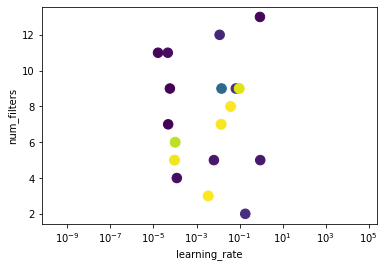

In [132]:
# START TODO ################ (2points)
final_validation_errors = []
for (model, config, val_errors) in results:
    final_validation_errors.append(val_errors[-1])
final_validation_errors = np.array(final_errors)
num_filters = [sum([config[key] for key in sorted(config.keys()) if key.startswith("num_filters")])for (model,config,val_errors) in results]
lrs = [config["lr"] for (model,config,val_errors) in results]

scaled_sizes = (final_validation_errors *10) + 90
plt.xscale("log")
plt.xlabel("learning_rate") 
plt.ylabel("num_filters")
plt.scatter(lrs, num_filters, s=scaled_sizes, c=final_validation_errors)
plt.show()
# END TODO ################

**Question:** What pattern do you see? Why might it occur? (1point)

**Answer:** **TODO** The validation error is lower, for higher learning rates. The number of filters doesn't affect it. We evaluate only after a short training (9 epochs), small learning rates converge not fast enough and high capacity isn't necessary.

After looking at the final error, let's now have a look at the training error.

**Task:** Plot error curves (error per epoch) for all your configurations in one figure.

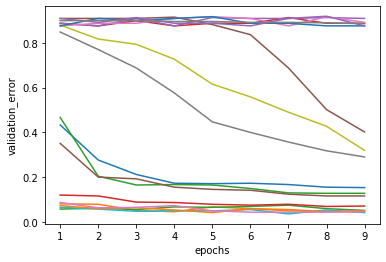

In [133]:
# START TODO ################ (1point)
for (model, config, val_errors) in results:
    plt.plot(range(1, 10), val_errors)
    
plt.xlabel("epochs")
plt.ylabel("validation_error")
plt.show()
# END TODO ################

**Questions:** How could you detect configurations with a low error earlier/faster? Why could this be problematic? 

**Answers:** **TODO** Learning curves with low error at the end usually have low error at earlier epochs. We could evaluate the error after only a few epochs (also possible: they are steeper). This might be problematic, because the best curve after a few epochs is not necessarily the best one after all epochs.
Therefore early evaluation might help filtering out poor configurations but may not find the best configuration.

## BOHB

Here we will use the more advanced hyperparameter optimizer [BOHB](https://www.automl.org/blog_bohb/) (Bayesian Optimization with Hyperband).
Based on TPE and [Hyperband](https://arxiv.org/pdf/1603.06560.pdf), BOHB evaluates configurations on your model with increasing budgets. In the context of Deep Learning, budget can be the number of epochs or the number of training samples. In lower budget evaluations, BOHB can look at more configurations. Full budget evaluations avoid missing configurations which are poor at the beginnning but good at the end (and vice versa). 
At the start of a run, BOHB samples configurations randomly. After some time, BOHB then uses a bayesian model (based on Parzen Tree Estimators), sampling only promising configs.

This exercise part is based on the [HpBandSter Examples](https://automl.github.io/HpBandSter/build/html/auto_examples/index.html) and the [HpBandSter Documentation](https://automl.github.io/HpBandSter/). *HpBandSter* provides a fast implementation of *Randomsearch*, *Hyperband* and *BOHB*. The optimization can easily be distributed between multiple cores or even multiple computers.

In [134]:
import pickle
import logging

from hpbandster.core.worker import Worker
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB

logging.getLogger('hpbandster').setLevel(logging.DEBUG)

### Implement Worker

The worker defines the hyperparameter problem which we try to optimize.
*compute(...)* should - for a given configuration and budget - return a loss which the hyperparameter optimizer tries to minimize. In our case, we can use the number of epochs as budget and the validation error as loss. 
As best practice, we define the configuration space also in the worker.

If you need help, you might get some inspiration from the [HpBandSter Pytorch Worker Example](https://automl.github.io/HpBandSter/build/html/auto_examples/example_5_pytorch_worker.html#sphx-glr-auto-examples-example-5-pytorch-worker-py).

**Task:** Complete the methods below.

In [135]:
class PyTorchWorker(Worker):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.train_loader, self.validation_loader, self.test_loader =\
            load_mnist_minibatched(batch_size=32, n_train=4096, n_valid=512)

    @staticmethod
    def get_model(config: CS.Configuration) -> nn.Module:
        """ Define a configurable convolution model.
            
        See description of get_conv_model above for more details on the model.
        """
        # START TODO ################ (1point)
        # raise NotImplementedError
        num_filters_per_layer = [config[k] for k in sorted(config.keys()) if k.startswith('num_filters')]
        return get_conv_model(num_filters_per_layer)
        # END TODO ################
        
    @staticmethod
    def get_configspace() -> CS.Configuration:
        """ Define a conditional hyperparameter search-space.
    
        hyperparameters:
          num_filters_1   from    4 to   32 (int)
          num_filters_2   from    4 to   32 (int)
          num_filters_3   from    4 to   32 (int)
          num_conv_layers from    1 to    3 (int)
          lr              from 1e-6 to 1e-1 (float, log)
          sgd_momentum    from 0.00 to 0.99 (float)
          optimizer            Adam or  SGD (categoric)
          
        conditions: 
          include num_filters_2 only if num_conv_layers > 1
          include num_filters_3 only if num_conv_layers > 2
          include sgd_momentum  only if       optimizer = SGD
        """
        # START TODO ################ (2points)
        cs = CS.ConfigurationSpace()
        num_filters_1 = CSH.UniformIntegerHyperparameter('num_filters_1',4,32)
        num_filters_2 = CSH.UniformIntegerHyperparameter('num_filters_2',4,32)
        num_filters_3 = CSH.UniformIntegerHyperparameter('num_filters_3',4,32)
        num_conv_layers = CSH.UniformIntegerHyperparameter("num_conv_layers",1,3)
        lr = CSH.UniformFloatHyperparameter("lr",1e-6,1e-1,log=True)
        sgd_momentum = CSH.UniformFloatHyperparameter("sgd_momentum",0.00,0.99)
        optimizer = CSH.CategoricalHyperparameter("optimizer",["Adam","SGD"])
        cs.add_hyperparameters([lr, num_filters_1, num_filters_2, num_conv_layers,num_filters_3,sgd_momentum,optimizer])
        cs.add_condition(CS.GreaterThanCondition(num_filters_2, num_conv_layers, 1))
        cs.add_condition(CS.GreaterThanCondition(num_filters_3, num_conv_layers, 2))
        cs.add_condition(CS.EqualsCondition(sgd_momentum,optimizer,"SGD"))
        return cs
        # END TODO ################

    def compute(self, config: CS.Configuration, budget: float, working_directory: str,
                *args, **kwargs) -> dict:
        """Evaluate a function with the given config and budget and return a loss.
        
        Bohb tries to minimize the returned loss.
        
        In our case the function is the training and validation of a model,
        the budget is the number of epochs and the loss is the validation error.
        """
        model = self.get_model(config)
        
        # START TODO ################ (3points)
        cross_entropy_loss = torch.nn.CrossEntropyLoss()
        if config["optimizer"] == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr = config["lr"])
        else:
            optimizer = torch.optim.SGD(model.parameters(), lr = config["lr"], momentum = config["sgd_momentum"])

        for epoch in range(int(budget)):
            loss = 0
            model.train()
            for i, (x, y) in enumerate(self.train_loader):
                optimizer.zero_grad()
                output = model(x)
                loss = cross_entropy_loss(output, y)
                loss.backward()
                optimizer.step()
        # END TODO ################
        
        train_accuracy = evaluate_accuracy(model, self.train_loader)
        validation_accuracy = evaluate_accuracy(model, self.validation_loader)
        test_accuracy = evaluate_accuracy(model, self.test_loader)
        
        return ({
                'loss': 1 - validation_accuracy,  # remember: HpBandSter minimizes the loss!
                'info': {'test_accuracy': test_accuracy,
                         'train_accuracy': train_accuracy,
                         'valid_accuracy': validation_accuracy,
                         'model': str(model)}
                })

   

It's best practice to do a quick sanity check of our worker with a low budget:

In [136]:
working_dir = os.curdir
# minimum budget that BOHB uses
min_budget = 1
# largest budget BOHB will use
max_budget = 9

In [137]:
worker = PyTorchWorker(run_id='0')
cs = worker.get_configspace()

config = cs.sample_configuration().get_dictionary()
print(config)

res = worker.compute(config=config, budget=min_budget, working_directory=working_dir)
print(res)

{'lr': 0.0008262792001504218, 'num_conv_layers': 3, 'num_filters_1': 15, 'optimizer': 'Adam', 'num_filters_2': 17, 'num_filters_3': 9}
{'loss': 0.58984375, 'info': {'test_accuracy': 0.3492, 'train_accuracy': 0.3603515625, 'valid_accuracy': 0.41015625, 'model': 'Sequential(\n  (Convolution1): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1))\n  (Relu1): ReLU()\n  (Max Pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (Convolution2): Conv2d(15, 17, kernel_size=(3, 3), stride=(1, 1))\n  (Relu2): ReLU()\n  (Max Pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (Convolution3): Conv2d(17, 9, kernel_size=(3, 3), stride=(1, 1))\n  (Relu3): ReLU()\n  (Max Pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (Flatten): Flatten()\n  (Linear): Linear(in_features=9, out_features=10, bias=True)\n  (Log Softmax): LogSoftmax()\n)'}}


### Run BOHB

We now run the hyperparameter search with BOHB and the worker which we defined above and save the result to disk. 
Try to understand what happens. *HpBandSter* allows to start additional workers on the same or remote devices to parallelize the executions, that's why we need to setup some network stuff (nameserver, nic, host, port, …). If you're interested, you can check this out in the [HpBandSter Examples](https://automl.github.io/HpBandSter/build/html/auto_examples/index.html), but it is beyond the scope of this exercise.

**Note:** The code below will try 60 different configurations. Some of them are executed at multiple budgets, which results in about 80 model training. Therefore it might take a while (15-45 minutes on a laptop). If you are interested in how BOHB works, checkout [BOHB (Falkner et al. 2018)](http://proceedings.mlr.press/v80/falkner18a.html).

**Note 2:** You can see the progress in the debug output below. The configuration identifier (called `config_id` in the docs) is a three-tuple `(current iteration, resampling in case of error, sample)`. 

In [122]:
result_file = os.path.join(working_dir, 'bohb_result.pkl')
nic_name = 'lo0'
port = 0
run_id = 'bohb_run_1'
n_bohb_iterations = 12

In [ ]:
try:
    # Start a nameserver
    host = hpns.nic_name_to_host(nic_name)
    ns = hpns.NameServer(run_id=run_id, host=host, port=port,
                         working_directory=working_dir)
    ns_host, ns_port = ns.start()

    # Start local worker
    w = PyTorchWorker(run_id=run_id, host=host, nameserver=ns_host,
                      nameserver_port=ns_port, timeout=120)
    w.run(background=True)

    # Run an optimizer
    bohb = BOHB(configspace=worker.get_configspace(),
                run_id=run_id,
                host=host,
                nameserver=ns_host,
                nameserver_port=ns_port,
                min_budget=min_budget, max_budget=max_budget)

    result = bohb.run(n_iterations=n_bohb_iterations)
    print("Write result to file {}".format(result_file))
    with open(result_file, 'wb') as f:
        pickle.dump(result, f)
finally:
    bohb.shutdown(shutdown_workers=True)
    ns.shutdown()

### Your Feedback on Exercise 9
